In [1]:
# Flippy Illusions

Hi! Welcome to the official colab demo for our demo "Diffusion Illusions: Hiding Images in Plain Sight". [https://ryanndagreat.github.io/Diffusion-Illusions/](https://ryanndagreat.github.io/Diffusion-Illusions/)

This project was inspired by our paper "Peekaboo: Text to Image Diffusion Models are Zero-Shot Segmentors". The Peekaboo project website: [https://ryanndagreat.github.io/peekaboo/](https://ryanndagreat.github.io/peekaboo/)

Instructions:

0. Go to the Runtime menu, and make sure this notebook is using GPU!
1. Run the top 2 code cells (one cleans colab's junk and downloads the source code, while the other installs python packages)
2. Click 'Runtime', then 'Restart Runtime'. You need to do this the first time you open this notebook to avoid weird random errors from the pip installations.
3. Run code cells to load stable diffusion. The first time you run it it will take a few minutes to download; subsequent times won't take long at all though.
4. Run all the cells below that, and customize prompt_a and prompt_b!
5. Take the result top_image and bottom_image, print them out, and shine a backlight through them like shown in the Diffusion Illusion website (link above!)

I may also create a YouTube tutorial if there's interest. Let me know if this would be helpful!

This notebook was written by Ryan Burgert. Feel free to reach out to me at rburgert@cs.stonybrook.edu if you have any questions! 

In [2]:
# %%bash
# if [ ! -d ".git" ]; then 
#     rm -rf * .*; #Get rid of Colab's default junk files
#     git clone -b master https://github.com/RyannDaGreat/Diffusion-Illusions .
# fi

In [3]:
# %pip install --upgrade -r requirements.txt
# %pip install rp --upgrade
# # You may need to restart the runtime after installing these
# # I'm not sure why this helps, but all sorts of weird random errors pop up in Colab if you don't

In [4]:
from rp import *
import numpy as np
import rp
import torch
import torch.nn as nn
import source.stable_diffusion as sd
from easydict import EasyDict
from source.learnable_textures import LearnableImageFourier
from source.stable_diffusion_labels import NegativeLabel
from itertools import chain
import time

/home/ryan/miniconda3/envs/diffilu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 1.12.1 with CUDA 1106 (you have 2.2.1+cu118)
    Python  3.10.13 (you have 3.10.13)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [31]:
#ONLY GOOD PROMPTS HERE
example_prompts = rp.load_yaml_file('source/example_prompts.yaml')
print('Available example prompts:', ', '.join(example_prompts))

#These prompts are all strings - you can replace them with whatever you want! By default it lets you choose from example prompts
#Here are some on the site! It does take some thought to come up with good ideas; the upside-down should look vaguely like the right-side up to work nicely
prompt_a, prompt_b = rp.gather(example_prompts, 'victorial_dress victorial_dress'.split())
prompt_a, prompt_b = rp.gather(example_prompts, 'pencil_giraffe_head pencil_penguin'.split())
prompt_a, prompt_b = rp.gather(example_prompts, 'emma_watson walter_white'.split())
prompt_a, prompt_b = rp.gather(example_prompts, 'sydney_opera_house mount_fuji'.split())
# prompt_a, prompt_b = rp.gather(example_prompts, 'sailing_ship sailing_ship'.split())
prompt_a = "A coffee mug, steamy ceramic coffee mug, 4k photography"
prompt_b = "A donut. A frosted donut with sprinkles, delicious 4k photography"

negative_prompt = ''

print()
print('Negative prompt:',repr(negative_prompt))
print()
print('Chosen prompts:')
print('    prompt_a =', repr(prompt_a)) #This will be right-side up
print('    prompt_b =', repr(prompt_b)) #This will be upside-down

Available example prompts: kitten_in_box, magic_emma_watson, emma_watson, yorkshire_terrier_santa, norwegian_winter_girl, magic_forest_temple, sailing_ship, bioshock_lighthouse, two_bunnys_hugging, thomas_tank_military, wolf_on_rock, victorial_dress, lolita_dress_magical_elf, pencil_giraffe_head, pencil_penguin, pencil_violin, pencil_orca_whale, pencil_cow, pencil_walrus, pencil_cat_head, pencil_dog_head, ape_with_gun, human_skeleton, gold_coins, bear_in_forest, mickey_mouse, mushroom, mario, burger, darth_vader, gandalf, fantasy_city, green_elf_girl, pikachu, spring, fall, winter, summer, miku, pyramids, dinosaur, lipstick, picard, bull_wing, froggo, assasin_creed, moon, minecraft_zombie, pistol, disco_ball, volcano, porche, hawaii_beach, walter_white, dalek, tardis, tennant, weeping_angel, stormtrooper, lowpoly_island, fire_magic_girl, fire_magic_man, the_one_ring, frodo, gollum, smaug, donut, sushi, icecream, strawberry, anime_bunny, anime_girl_under_stars, anime_witch_girl, samurai

# New Section

In [32]:
if 's' not in dir():
    model_name="CompVis/stable-diffusion-v1-4"
    model_name="runwayml/stable-diffusion-v1-5"
    # model_name="nitrosocke/Arcane-Diffusion"
    gpu='cuda:0'
    s=sd.StableDiffusion(gpu,model_name)
device=s.device

In [33]:
label_a = NegativeLabel(prompt_a,negative_prompt)
label_b = NegativeLabel(prompt_b,negative_prompt)

In [34]:
#Image Parametrization and Initialization (this section takes vram)

#Select Learnable Image Size (this has big VRAM implications!):
#Note: We use implicit neural representations for better image quality
#They're previously used in our paper "TRITON: Neural Neural Textures make Sim2Real Consistent" (see tritonpaper.github.io)
# ... and that representation is based on Fourier Feature Networks (see bmild.github.io/fourfeat)
# learnable_image_maker = lambda: LearnableImageFourier(height=256, width=256, hidden_dim=256, num_features=128).to(s.device); SIZE=256

# learnable_image_maker = lambda: LearnableImageFourier(height=512,width=512,num_features=256,hidden_dim=256,scale=20).to(s.device);SIZE=512
learnable_image_maker = lambda: LearnableImageFourier(height=300,width=300,num_features=256,hidden_dim=256,scale=20).to(s.device);SIZE=512



image=learnable_image_maker()

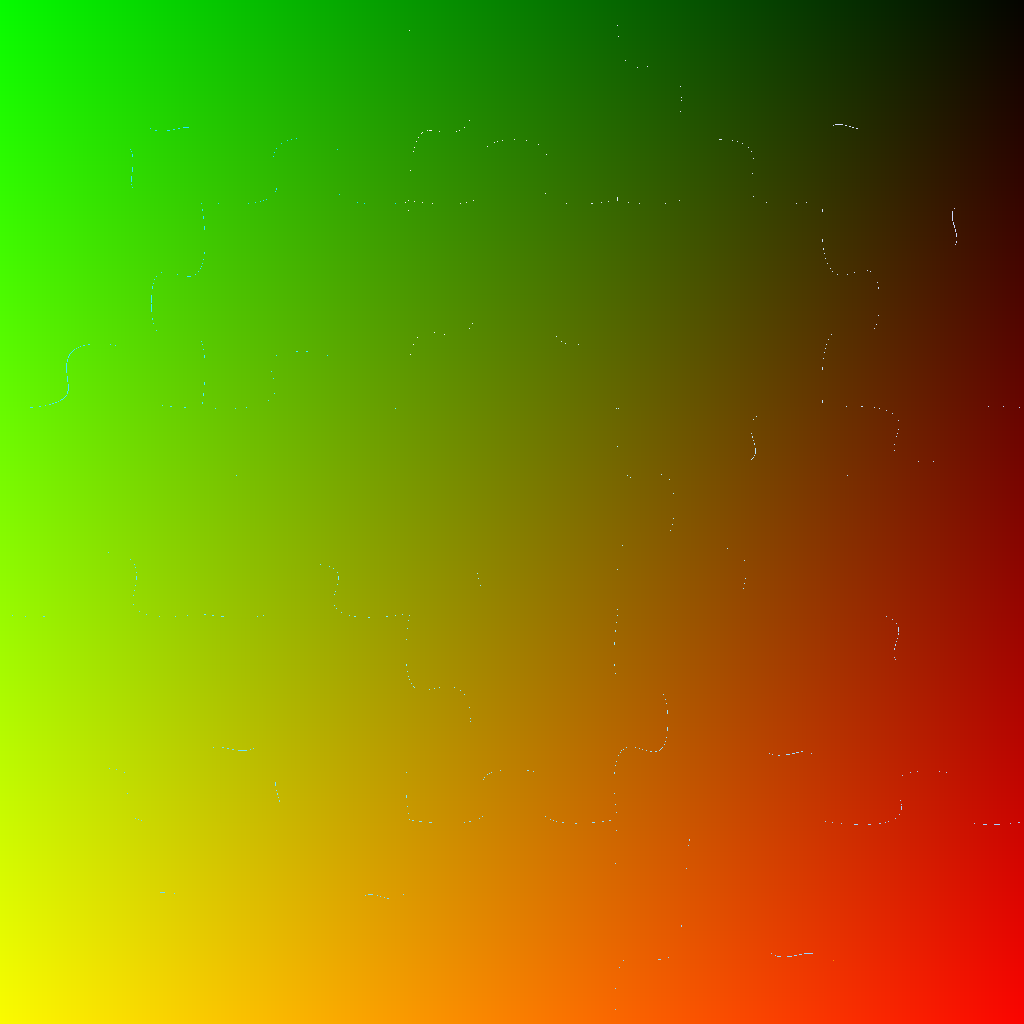

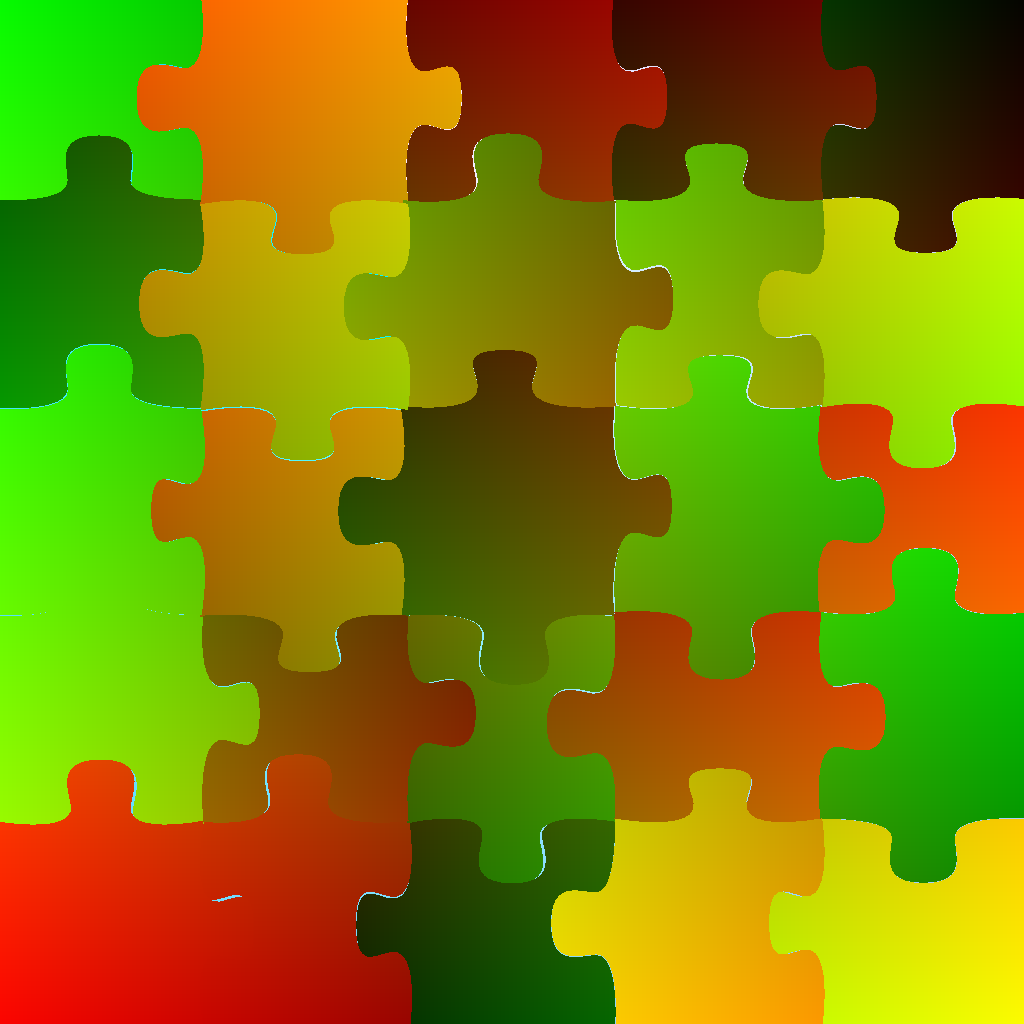

In [35]:
# 2023-12-20 04:37:25.394973
import torch
import torch.nn.functional as F

def rotate_tiles(image, num_divisions=4):
    image=as_torch_image(image)
    # Assuming image is a tensor of shape (num_channels, height, width)
    num_channels, height, width = image.shape

    tile_size=width//num_divisions
    
    # Calculate the number of tiles in each dimension
    tiles_x = width // tile_size
    tiles_y = height // tile_size

    # Initialize an output tensor
    output = torch.zeros_like(image)

    for x in range(tiles_x):
        for y in range(tiles_y):
            # Extract the tile
            tile = image[:, y*tile_size:(y+1)*tile_size, x*tile_size:(x+1)*tile_size]

            # Check if the tile should be rotated 90 or -90 degrees (checker pattern)
            if (x + y) % 2 == 0:
                # Rotate 90 degrees
                tile = tile.rot90(1, [1, 2])
            else:
                # Rotate -90 degrees
                tile = tile.rot90(-1, [1, 2])

            # Place the rotated tile back in the output tensor
            output[:, y*tile_size:(y+1)*tile_size, x*tile_size:(x+1)*tile_size] = tile

    return output


uv_map_a = "UV_Maps/ParkerPuzzleSep7_UV_Label_Exr/Image0000.exr"
uv_map_b = "UV_Maps/ParkerPuzzleSep7_UV_Label_Exr/Image0113.exr"
uv_map_a = rp.as_torch_image(rp.load_image(uv_map_a, use_cache=True)).to(device)
uv_map_b = rp.as_torch_image(rp.load_image(uv_map_b, use_cache=True)).to(device)

def apply_uv_map(texture,uv_map):
    uv_map = rp.torch_resize_image(uv_map, size=rp.get_image_dimensions(texture))
    x=uv_map[1,:,:]
    y=uv_map[0,:,:]
    x*=get_image_width(texture)
    y*=get_image_height(texture)
    out=torch_remap_image(texture,x,y)
    return out

rp.display_image(uv_map_a)
rp.display_image(uv_map_b)

# learnable_image_a=lambda: image() #Right-side up
# learnable_image_b=lambda: image().rot90(k=2,dims=[1,2]) #Upside-down
# learnable_image_b=lambda: rotate_tiles(image()) #Upside-down

learnable_image_a = lambda: apply_uv_map(image(), uv_map_a)
learnable_image_b = lambda: apply_uv_map(image(), uv_map_b)

optim=torch.optim.SGD(image.parameters(),lr=1e-4)

In [36]:
labels=[label_a,label_b]
learnable_images=[learnable_image_a,learnable_image_b]

#The weight coefficients for each prompt. For example, if we have [0,1], then only the upside-down mode will be optimized
weights=[2,9]

weights=rp.as_numpy_array(weights)
weights=weights/weights.sum()
weights=weights*len(weights)

In [37]:
#For saving a timelapse
ims=[]

In [38]:
def get_display_image():
    return rp.tiled_images(
        [
            rp.as_numpy_image(learnable_image_a()),
            rp.as_numpy_image(learnable_image_b()),
        ],
        length=len(learnable_images),
        border_thickness=0,
    )

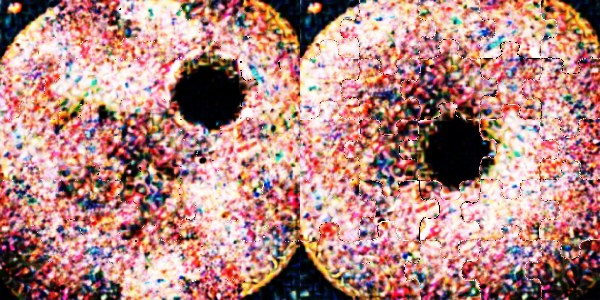

Every 200 iterations we display an image in the form [image_a, image_b], where
    image_a = (the right-side up image)
    image_b = (image_a, but upside down)

Interrupt the kernel at any time to return the currently displayed image
You can run this cell again to resume training later on

Please expect this to take quite a while to get good images (especially on the slower Colab GPU's)! The longer you wait the better they'll be


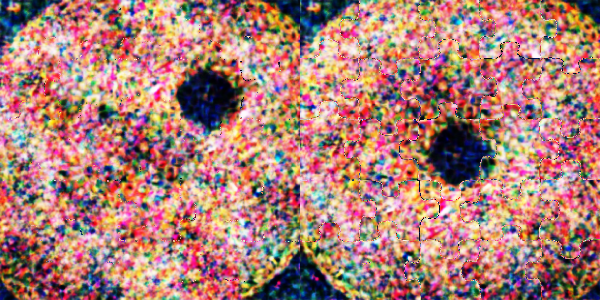

Status: ETR=37 days, 0:10:57.938772	ETA=37 days, 0:12:01.889210	T=0:01:03.950438	Progress: 200/1000000000

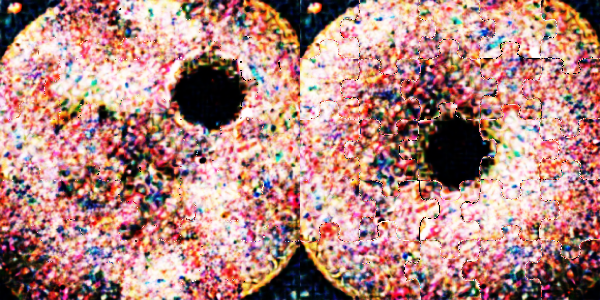

Status: ETR=37 days, 1:53:02.018417	ETA=37 days, 1:55:00.555337	T=0:01:58.536921	Progress: 370/10000000

In [ ]:
NUM_ITER=10000000

#Set the minimum and maximum noise timesteps for the dream loss (aka score distillation loss)
s.max_step=MAX_STEP=990
s.min_step=MIN_STEP=10 

television = rp.JupyterDisplayChannel()
television.display()

display_eta=rp.eta(NUM_ITER, title='Status')

DISPLAY_INTERVAL = 200

print('Every %i iterations we display an image in the form [image_a, image_b], where'%DISPLAY_INTERVAL)
print('    image_a = (the right-side up image)')
print('    image_b = (image_a, but upside down)')
print()
print('Interrupt the kernel at any time to return the currently displayed image')
print('You can run this cell again to resume training later on')
print()
print('Please expect this to take quite a while to get good images (especially on the slower Colab GPU\'s)! The longer you wait the better they\'ll be')

try:
    for iter_num in range(NUM_ITER):
        display_eta(iter_num) #Print the remaining time

        preds=[]
        for label,learnable_image,weight in rp.random_batch(list(zip(labels,learnable_images,weights)), batch_size=1):
            pred=s.train_step(
                label.embedding,
                learnable_image()[None],

                #PRESETS (uncomment one):
                noise_coef=.1*weight,guidance_scale=100,#10
                # noise_coef=0,image_coef=-.01,guidance_scale=50,
                # noise_coef=0,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1,image_coef=-.010,guidance_scale=50,
                # noise_coef=.1,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1*weight, image_coef=-.005*weight, guidance_scale=50,
            )
            preds+=list(pred)

        with torch.no_grad():
            if iter_num and not iter_num%(DISPLAY_INTERVAL*50):
                #Wipe the slate every 50 displays so they don't get cut off
                from IPython.display import clear_output
                clear_output()

            if not iter_num%DISPLAY_INTERVAL//4:
                television.update(im)
                im = get_display_image()
                ims.append(im)
                
                if not iter_num%DISPLAY_INTERVAL:
                    rp.display_image(im)

        optim.step()
        optim.zero_grad()
except KeyboardInterrupt:
    print()
    print('Interrupted early at iteration %i'%iter_num)
    im = get_display_image()
    ims.append(im)
    rp.display_image(im)

In [ ]:
print('Right-side up image:')
rp.display_image(rp.as_numpy_image(learnable_image_a()))

print('Upside-down image:')
rp.display_image(rp.as_numpy_image(learnable_image_b()))

In [ ]:
def save_run(name):
    folder="untracked/flippy_illusion_runs/%s"%name
    if rp.path_exists(folder):
        folder+='_%i'%time.time()
    rp.make_directory(folder)
    ims_names=['ims_%04i.png'%i for i in range(len(ims))]
    with rp.SetCurrentDirectoryTemporarily(folder):
        rp.save_images(ims,ims_names,show_progress=True)
    print()
    print('Saved timelapse to folder:',repr(folder))
    
save_run('-'.join([prompt_a,prompt_b])) #You can give it a good custom name if you want!

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline
pipe_im2im=StableDiffusionImg2ImgPipeline(
    vae                     = s.pipe.vae                          ,
    text_encoder            = s.pipe.text_encoder                 ,
    tokenizer               = s.pipe.tokenizer                    ,
    unet                    = s.pipe.unet                         ,
    scheduler               = s.pipe.scheduler                    ,
    safety_checker          = s.pipe.safety_checker               ,
    feature_extractor       = s.pipe.feature_extractor            ,
    requires_safety_checker = s.pipe.requires_safety_checker      ,
)


In [ ]:
import requests
import torch
from PIL import Image
from io import BytesIO
from diffusers import StableDiffusionImg2ImgPipeline
device = "cuda"
# model_id_or_path = "runwayml/stable-diffusion-v1-5"
# pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
# pipe = pipe.to(device)
url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"
response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))
prompt = "A fantasy landscape, trending on artstation"
images = pipe_im2im(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
images[0].save("fantasy_landscape.png")